In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
from sklearn import preprocessing
import glob
from skimage.measure import block_reduce
import tqdm.notebook
from datetime import datetime
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')

import src.utils
from src.utils import set_gpytorch_settings
# import GPUtil
set_gpytorch_settings()
# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from src.custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval
# from gpytorch.metrics import mean_standardized_log_loss, quantile_coverage_error, mean_squared_error, mean_absolute_error
from src.custom_kernel import noise_lower, noise_upper, noise_init

['C:\\Users\\dcaos\\OneDrive\\Documents\\GitHub\\GaussProcesses\\notebooks', 'C:\\Users\\dcaos\\OneDrive\\Documents\\GitHub\\GaussProcesses', 'C:\\Users\\dcaos\\anaconda3\\envs\\GPs\\python39.zip', 'C:\\Users\\dcaos\\anaconda3\\envs\\GPs\\DLLs', 'C:\\Users\\dcaos\\anaconda3\\envs\\GPs\\lib', 'C:\\Users\\dcaos\\anaconda3\\envs\\GPs', '', 'C:\\Users\\dcaos\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\dcaos\\anaconda3\\envs\\GPs\\lib\\site-packages', 'C:\\Users\\dcaos\\anaconda3\\envs\\GPs\\lib\\site-packages\\win32', 'C:\\Users\\dcaos\\anaconda3\\envs\\GPs\\lib\\site-packages\\win32\\lib', 'C:\\Users\\dcaos\\anaconda3\\envs\\GPs\\lib\\site-packages\\Pythonwin', 'C:\\Users\\dcaos\\OneDrive\\Documents\\GitHub\\GaussProcesses']


(7510949888, 8589475840)
Before Block Reduce: (174818, 2)
After Block Reduce: (7285, 2)
Number of Nans: 0
Start Time: 2012-09-30 16:55:44
End Time: 2023-02-22 23:25:52
Number of Days: 3642.0416666666665
Time Period (Days): 3797.312592592593


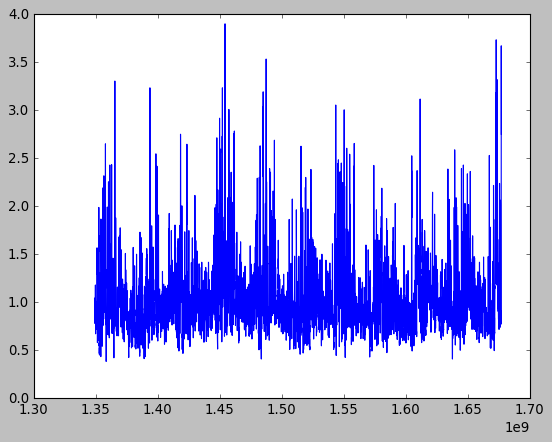

In [2]:
print(torch.cuda.mem_get_info(device=None))
df = pd.read_feather('../data/feather/46221_9999_wave_height.feather')
# df = pd.read_feather('../data/feather/combined/combined_data.feather')
parameters_wave = ['time', 'wave_height']
parameters_temp = ['time', 'sea_surface_temperature']
df_as_np = df \
    .loc[:, parameters_wave] \
    .astype(float) \
    .replace(to_replace = [999.0, 99.0, 9999.0], value = np.nan) \
    .to_numpy()
using_sk = block_reduce(df_as_np, block_size=(24,1), func=np.mean).astype(float)
plt.plot(using_sk[:-1,0], using_sk[:-1,1])

print(f'Before Block Reduce: {df_as_np.shape}\n'
      f'After Block Reduce: {using_sk.shape}\n'
      f'Number of Nans: {np.count_nonzero(np.isnan(df_as_np))}\n'
      f'Start Time: {datetime.fromtimestamp(df_as_np[0,0])}\n'
      f'End Time: {datetime.fromtimestamp(df_as_np[-1,0])}\n'
      f'Number of Days: {df_as_np.shape[0]/48}\n'
      f'Time Period (Days): {(df_as_np[-1,0] - df_as_np[0,0]) / 24 / 60 / 60}')

In [3]:
X = torch.tensor(using_sk[:-1,0]).float().cuda()#.type(torch.double)
y = torch.tensor(using_sk[:-1,1]).float().cuda()#.type(torch.double)
X = X.reshape(-1,1)
y = y.reshape(-1,1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X

In [4]:
X_old

tensor([[1.3491e+09],
        [1.3491e+09],
        [1.3492e+09],
        ...,
        [1.6770e+09],
        [1.6771e+09],
        [1.6771e+09]])

In [5]:
def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)

def descaler(a, X_old=X_old, center=True):
    if center is True:
        a = a * (X_old.max(0).values - X_old.min(0).values)
    return a + X_old.min(0).values
X = scaler(X, X_old)
y = y.log()



In [6]:
# max and min
scaler_max = X_old.max(0).values.item()
scaler_min = X_old.min(0).values.item()

scale_factor = scaler_max - scaler_min
print(scaler_max, scaler_min, scale_factor)

1677108352.0 1349069952.0 328038400.0


In [7]:
predict_days_out = 14
test_n = 2*predict_days_out
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

In [8]:
# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = src.utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [9]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MeanFieldApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MAPApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def make_orthogonal_vs(model, train_x):
    mean_inducing_points = torch.randn(1000, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)
    covar_inducing_points = torch.randn(100, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)

    covar_variational_strategy = gpytorch.variational.VariationalStrategy(
        model, covar_inducing_points,
        gpytorch.variational.CholeskyVariationalDistribution(covar_inducing_points.size(-2)),
        learn_inducing_locations=True
    )

    variational_strategy = gpytorch.variational.OrthogonallyDecoupledVariationalStrategy(
        covar_variational_strategy, mean_inducing_points,
        gpytorch.variational.DeltaVariationalDistribution(mean_inducing_points.size(-2)),
    )
    return variational_strategy

class OrthDecoupledApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = make_orthogonal_vs(self, train_x)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralDeltaGP(gpytorch.models.ExactGP):
    # def __init__(self, train_x, train_y, kernel, num_deltas, noise_init=None):
    #     likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-11))
    #     likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
    #     likelihood.noise = 1e-2
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points)
        #variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        #super(SpectralDeltaGP, self).__init__(train_x, train_y, likelihood)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        #base_covar_module = kernel #gpytorch.kernels.SpectralDeltaKernel(num_dims=train_x.size(-1), num_deltas=num_deltas)
        #base_covar_module.initialize_from_data(train_x[0], train_y[0])
        self.covar_module = kernel#gpytorch.kernels.ScaleKernel(base_covar_module)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [10]:
def period_print(x):
  print(f"raw: {x}")
  print(f"seconds: {x * (scale_factor)}")
  print(f"minutes: {x * (scale_factor) / 60}")
  print(f"hours: {x * (scale_factor) / 60 / 60 }")
  print(f"days: {x * (scale_factor) / 60 / 60 / 24}")
  print(f"weeks: {x * (scale_factor) / 60 / 60 / 24 / 7}")
  print(f"months: {x * (scale_factor) / 60 / 60 / 24 / 30}")
  print(f"years: {x * (scale_factor) / 60 / 60 / 24 / 365}")


Mat32 = MaternKernel(nu=1.5)
Mat12 = MaternKernel(nu=0.5)
Mat52 = MaternKernel(nu=2.5)
RBF = RBFKernel()
Per_Week = PeriodicKernel(
    period_length_constraint=Interval(
    # lower_bound=scaler(60*60*24*7, center=False) / 100,
    lower_bound=1e-4, upper_bound=1,
    # upper_bound=scaler(60*60*24*7, center=False) * 100,
    initial_value=scaler(60*60*24*7, center=False))
)
Per_Month = PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=1e-4, upper_bound=1,
    # lower_bound=scaler(60*60*24*30, center=False) / 100,
    # upper_bound=scaler(60*60*24*30, center=False) * 100,
    initial_value=scaler(60*60*24*30, center=False))
)
Per_Arb = PeriodicKernel()

k_1 = [Mat32, Mat12, RBF, Per_Week, Per_Month, Per_Arb]
k_2 = [*k_1]
k_3 = [*k_1]
kernel_dict = {
    Mat32: 'Mat32',
    Mat12: 'Mat12',  # Very Rough - in continuous time AR(1) process in discrete time
    Mat52: 'Mat52', # Matern 5/2 (Default)
    RBF: 'RBF',
    Per_Week: 'Per_Week',
    Per_Month: 'Per_Month',
    Per_Arb: 'Per_Arb'}
from gpytorch.kernels import RQKernel
RQKernel()

RQKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_alpha_constraint): Positive()
)

In [11]:
# period_print((scaler(60*60*24, center=False) * 1).item())
# period_print((1e-4))

In [13]:
## Kernel Experimentation for periodicity
# kernel = ScaleKernel(PeriodicKernel()) +ScaleKernel(PeriodicKernel()*RBFKernel())  + ScaleKernel(PeriodicKernel()*RBFKernel()) + ScaleKernel(PeriodicKernel()*RBFKernel())
def make_kernel(name_of_kernel):
    if name_of_kernel == 'RBF':
        return RBFKernel()
    elif name_of_kernel.startswith('Mat'):
        nu_value = float(name_of_kernel[-3:])
        return MaternKernel(nu=nu_value)
    if name_of_kernel.startswith('Per'):
        if name_of_kernel == 'Per_Arb':
            return PeriodicKernel()
        elif name_of_kernel == 'Per_Week':
            return PeriodicKernel(
                period_length_constraint=Interval(
                lower_bound=1e-4, upper_bound=1,
                initial_value=scaler(60*60*24*7, center=False)))
        elif name_of_kernel == 'Per_Month':
            return PeriodicKernel(
                period_length_constraint=Interval(
                lower_bound=1e-4, upper_bound=1,
                initial_value=scaler(60*60*24*30, center=False)))
    else:
        raise ValueError('Kernel not found')

# kernel = ScaleKernel(RBFKernel()) + ScaleKernel(Per_Month * RBFKernel())
# kernel_0 = ScaleKernel(RBFKernel()) + ScaleKernel(Per_Week * RBFKernel())
# kernel_1 = ScaleKernel(MaternKernel(nu=2.5)) + ScaleKernel(PeriodicKernel() * RBFKernel())
# kernel_2 = ScaleKernel(MaternKernel(nu=1.5)) + ScaleKernel(PeriodicKernel() * RBFKernel())
# kernel_3 = ScaleKernel(MaternKernel(nu=0.5)) + ScaleKernel(PeriodicKernel() * RBFKernel())

smooth_kernel_list_1 = ['RBF', 'Mat0.5', 'Mat1.5', 'Mat2.5']
smooth_kernel_list_2 = ['RBF', 'Mat0.5', 'Mat1.5', 'Mat2.5']
periodic_kernel_list = ['Per_Arb', 'Per_Week', 'Per_Month']

bic_save = []
index_checker = 0
# try:
for sk1 in smooth_kernel_list_1:
    for sk2 in smooth_kernel_list_2:
        for pk in periodic_kernel_list:
            kernel = ScaleKernel(make_kernel(sk1)) + ScaleKernel(make_kernel(pk) * make_kernel(sk2))
            name_of_kernel = f'{sk1}plus{sk2}x{pk}_exact_gp'
            k_list = [str(sk1), str(pk), str(sk2)]
            exact_gp = src.utils.TrainTestPlotSaveExactGP(
                ExactGPModel, kernel,
                train_x, train_y, test_x, test_y,
                num_iter=1000, lr=0.0063,
                name=name_of_kernel)
            exact_gp.test_eval_exact_gp()
            exact_gp.plot(show_plot=False)
            bic_save.append([
                *k_list,
                exact_gp.get_BIC().item,
                kernel.kernels[0].base_kernel.lengthscale.item(),
                kernel.kernels[1].base_kernel.kernels[1].lengthscale.item(),
                kernel.kernels[1].base_kernel.kernels[0].lengthscale.item(),
                kernel.kernels[1].base_kernel.kernels[0].period_length.item()])
            print("Kernel Structure: ", *k_list)
            print("BIC: ", exact_gp.get_BIC().item())
            print("Iterations Number: ",index_checker)
            print("Memory Check: ", torch.cuda.mem_get_info(device=None))
            index_checker += 1
            del exact_gp
            del kernel
            gc.enable()
            gc.collect()
            torch.cuda.empty_cache()
bic_out_df = pd.DataFrame(bic_save, columns=['Name', 'BIC', 's1_ls', 's2_ls', 'pk_ls', 'pk_pr', 'Kernel Structure'])
bic_out_df.to_csv('bic_save_2.csv')
# except:
#     print("Error")
#     pd.DataFrame(bic_save, columns=['Name', 'BIC', 'Full Kernel', 'Period']).to_csv('bic_save.csv')

            # GPUtil.showUtilization(all=True)


Training_exactGPRBFplusRBFxPer_Arb_exact_gp:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
bic_out_df = pd.DataFrame(bic_save, columns=['Name', 'BIC', 's1_ls', 's2_ls', 'pk_ls', 'pk_pr', 'Kernel Structure'])
bic_out_df.to_csv('bic_save_2.csv')
bic_out_df
# def period_print(x):
#   print(f"raw: {x}")
#   print(f"seconds: {x * (scale_factor)}")
#   print(f"minutes: {x * (scale_factor) / 60}")
#   print(f"hours: {x * (scale_factor) / 60 / 60 }")
#   print(f"days: {x * (scale_factor) / 60 / 60 / 24}")
#   print(f"weeks: {x * (scale_factor) / 60 / 60 / 24 / 7}")
#   print(f"months: {x * (scale_factor) / 60 / 60 / 24 / 30}")
#   print(f"years: {x * (scale_factor) / 60 / 60 / 24 / 365}")

,Name,BIC,s1_ls,s2_ls,pk_ls,pk_pr,Kernel Structure


In [ ]:
bic_out_df
# print(bic_save)
# for i in bic_save:
#     period_print(i[-1].item(), "\n------------------")
# kernel.kernels[-1].base_kernel.kernels[0].period_length
# period_print(scaler(60*60*24, center=False).item())

In [ ]:
# # Lengthscale for first smoothing kernel
# print(bic_save[-1][2].kernels[0].base_kernel.lengthscale.item())
# # Lengthscale for second smoothing kernel inside the product
# print(bic_save[-1][2].kernels[1].base_kernel.kernels[1].lengthscale.item())
# # Lengthscale and Period for periodic kernel inside the product
# print(bic_save[-1][2].kernels[1].base_kernel.kernels[0].period_length.item())
# print(bic_save[-1][2].kernels[1].base_kernel.kernels[0].lengthscale.item())
# print(bic_save[-1][0])
# new_bic_save = []
# for i in bic_save:
#     name = i[0]
#     bic = i[1].item()
#     s1_ls = i[2].kernels[0].base_kernel.lengthscale.item()
#     s2_ls = i[2].kernels[1].base_kernel.kernels[1].lengthscale.item()
#     pk_ls = i[2].kernels[1].base_kernel.kernels[0].lengthscale.item()
#     pk_pr = i[2].kernels[1].base_kernel.kernels[0].period_length.item()
#     new_bic_save.append([name, bic, s1_ls, s2_ls, pk_ls, pk_pr])
# new_bic_save_df = pd.DataFrame(
#     new_bic_save, columns=['Name', 'BIC', 's1_ls', 's2_ls', 'pk_ls', 'pk_pr'])
# new_bic_save_df.to_csv('new_bic_save.csv')
# new_bic_save_df



In [ ]:
# # kernel = ScaleKernel(RBFKernel()) + ScaleKernel(MaternKernel()) + ScaleKernel(PeriodicKernel())
# kernel = ScaleKernel(RBFKernel() * RBFKernel()) + ScaleKernel(PeriodicKernel() * MaternKernel()) + ScaleKernel(PeriodicKernel() * RBFKernel()) + ScaleKernel(PeriodicKernel() * RBFKernel())
# # kernel = ScaleKernel(RBFKernel()) #+ ScaleKernel(MaternKernel()) + ScaleKernel(PeriodicKernel())
# kernel = ScaleKernel(MaternKernel(nu=0.5))
#
#
#
# results = []
# # for i in range(150, 200):
# exact_gp = src.utils.TrainTestPlotSaveExactGP(
#     ExactGPModel, kernel,
#     train_x, train_y, test_x, test_y, num_iter=250,
#     name=f'_Mat_RBF')
# exact_gp.test_eval_exact_gp()
# exact_gp.plot()
# bic = exact_gp.get_BIC()
# print(bic, kernel)
# results.append([bic, kernel])
# # del exact_gp
# # print(f'BIC: {exact_gp.get_BIC()}')
# # print(f'AVG Error: {error}')

In [ ]:
# torch.cuda.mem_get_info(device=None)
# exact_gp.plot(set_x_limit=(.992,1))#, set_y_limit=(0,4))

In [ ]:
# print(exact_gp.get_BIC())
# del exact_gp


In [ ]:
## Test all combinations of kernels

# for i in k_1:
#     for j in k_2:
#         for z in k_3:
#             kernel = (
#                 ScaleKernel(i) +
#                 ScaleKernel(j) +
#                 ScaleKernel(z))
#             exact_gp = src.utils.TrainTestPlotSaveExactGP(
#                 ExactGPModel, kernel,
#                 train_x, train_y, test_x, test_y,
#                 name=f'{str(kernel_dict[i])}{str(kernel_dict[j])}{str(kernel_dict[z])}')
#             exact_gp.test_eval_exact_gp()